<a href="https://colab.research.google.com/github/hanyikoh/Plant-Disease-Classification-with-Deep-Learning/blob/main/plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
dataset = 'Malaysia Plant Dataset' #@param ["Malaysia Plant Dataset", "PlantVillage Dataset"]
isAugmented = True #@param ['True', 'False']

if dataset == "Malaysia Plant Dataset":
  if isAugmented:
    !kaggle datasets download -d kohhanyi/augmented-malaysiaplant-dataset
    !unzip augmented-malaysiaplant-dataset
    data_dir = "/content/Augmented Malaysaiplant Dataset"
  else:
    !kaggle datasets download -d kohhanyi/malaysia-plant-disease
    !unzip malaysia-plant-disease
    data_dir = "/content/Malaysia Plant Disease"
elif dataset == "PlantVillage Dataset":
  !kaggle datasets download -d abdallahalidev/plantvillage-dataset
  ! unzip plantvillage-dataset
  data_dir = "/content/plantvillage dataset/color"

Streaming output truncated to the last 5000 lines.
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0016_jpeg_jpg.rf.802674016a2b0cd3d4a61df3ad641a18.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0016_jpeg_jpg.rf.8078436d5b2d7b92988ed16c1087c1de.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0016_jpeg_jpg.rf.80f472a4b6c75c0a16097c105fa0def1.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0016_jpeg_jpg.rf.8d7e87f355548aa9517dde9be22175ed.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0016_jpeg_jpg.rf.95d4bcf6cb29f81b66531512900da8fb.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0021_jpeg.rf.54a4145f7dd2390d9fca72ab6321f5a1.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0021_jpeg.rf.86a7850fbea92dc7da75a0889854e95a.jpg  
  inflating: Augmented Malaysaiplant Dataset/Banana___healthy/Baidu_0021_jpeg_jpg.rf.20de

In [ ]:
!rmdir "/content/Augmented Malaysaiplant Dataset/.ipynb_checkpoints"

rmdir: failed to remove '/content/Augmented Malaysaiplant Dataset/.ipynb_checkpoints': No such file or directory


In [163]:
%matplotlib inline
%load_ext tensorboard
import shutil
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import sklearn.metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from keras import backend as K

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from glob2 import glob
import seaborn as sns

print("Done importing packages!")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Done importing packages!


In [164]:
!pwd

/content


### Data Exploratory

In [ ]:
import pandas as pd
import os
import seaborn as sns

In [ ]:
category_count = []

for root, dirs, files in os.walk(data_dir):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))

In [ ]:
count_df = pd.DataFrame(category_count, columns=['Category', 'Count'])
count_df.head(10)

,Category,Count
0,Corn_(maize)___Northern_Leaf_Blight,340
1,"Pepper,_bell___Bacterial_spot",1000
2,"Pepper,_bell___healthy",1008
3,Banana___healthy,1021
4,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,336
5,Corn_(maize)___Common_rust_,341
6,Banana___Panama,438
7,Banana___Sigatoka,504
8,Corn_(maize)___healthy,1005


In [ ]:
total_images = count_df['Count'].sum()
total_images

5993

[]

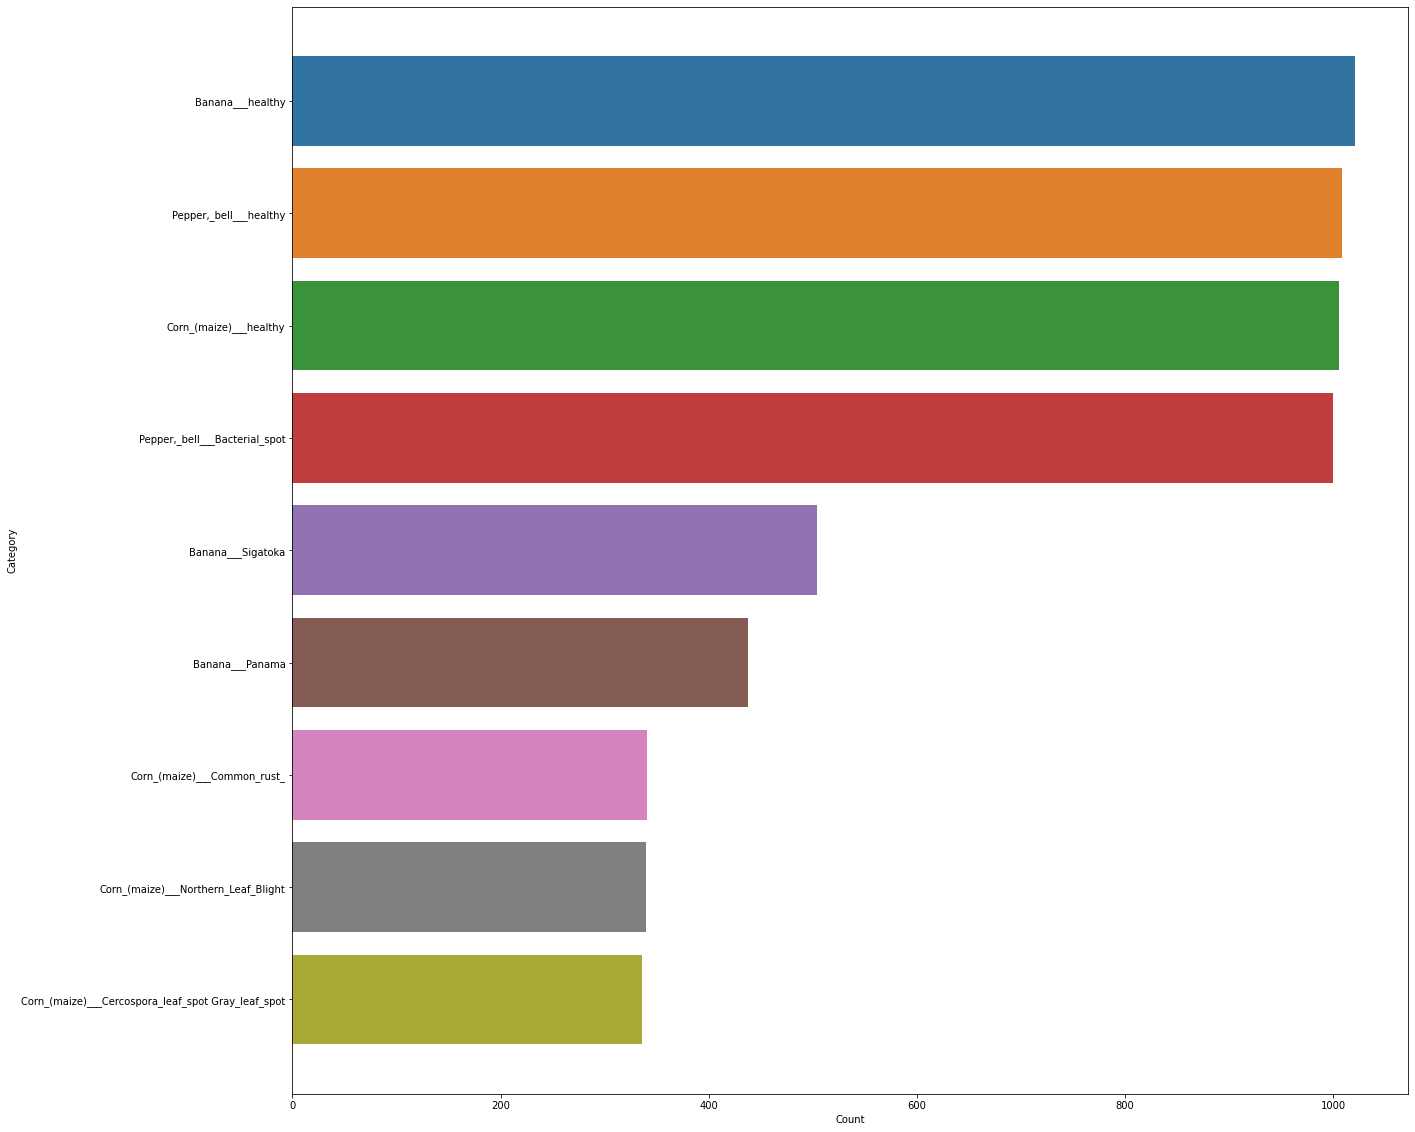

In [ ]:
count_df = count_df.sort_values(by='Count', ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x="Count", y="Category", data=count_df)
plt.plot()

### Model Config and Function Setup

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path = '/output/Checkpoint/'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 5993 files belonging to 9 classes.
Using 4795 files for training.
Found 5993 files belonging to 9 classes.
Using 1198 files for validation.


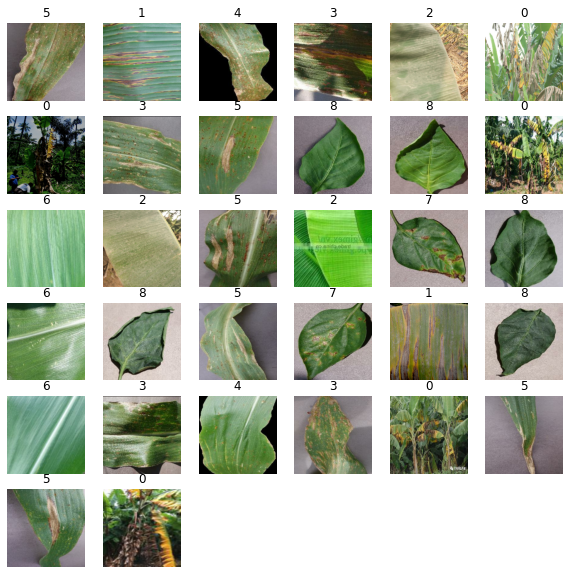

In [ ]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = str(np.argmax(labels[i], axis=0))
        plt.title(title)
        plt.axis("off")


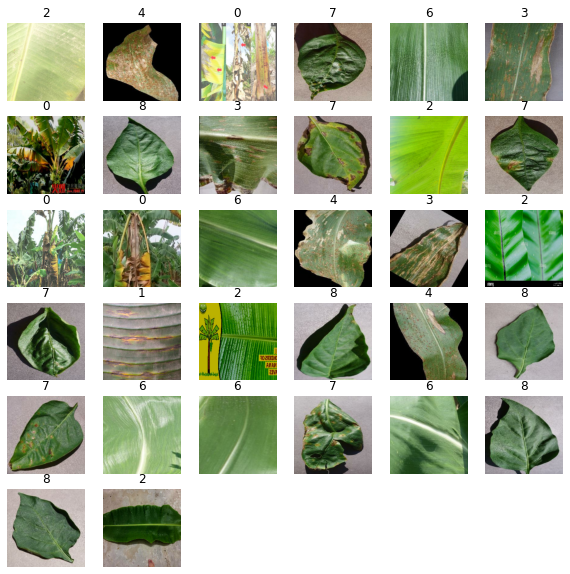

In [ ]:
plt.figure(figsize=(10, 10))
class_names = validation_dataset.class_names
for images, labels in validation_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        title = str(np.argmax(labels[i], axis=0))
        plt.title(title)
        plt.axis("off")


In [ ]:
if dataset == "PlantVillage Dataset":
  class_list = {
      '0':  'Apple___Apple_scab',
      '1' : 'Apple___Black_rot',
      '2' : 'Apple___Cedar_apple_rust',
      '3' : 'Apple___healthy',
      '4' : 'Blueberry___healthy',
      '5' : 'Cherry_(including_sour)___Powdery_mildew',
      '6' : 'Cherry_(including_sour)___healthy',
      '7' : 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
      '8' : 'Corn_(maize)___Common_rust_',
      '9' :'Corn_(maize)___Northern_Leaf_Blight',
      '10' : 'Corn_(maize)___healthy',
      '11' : 'Grape___Black_rot',
      '12' : 'Grape___Esca_(Black_Measles)',
      '13' : 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
      '14' : 'Grape___healthy',
      '15' : 'Orange___Haunglongbing_(Citrus_greening)',
      '16' : 'Peach___Bacterial_spot',
      '17' : 'Peach___healthy',
      '18' : 'Pepper,_bell___Bacterial_spot',
      '19' : 'Pepper,_bell___healthy',
      '20' : 'Potato___Early_blight',
      '21' : 'Potato___Late_blight',
      '22' : 'Potato___healthy',
      '23' : 'Raspberry___healthy',
      '24' : 'Soybean___healthy',
      '25' : 'Squash___Powdery_mildew',
      '26' : 'Strawberry___Leaf_scorch',
      '27' : 'Strawberry___healthy',
      '28' : 'Tomato___Bacterial_spot',
      '29' : 'Tomato___Early_blight',
      '30' : 'Tomato___Late_blight',
      '31' : 'Tomato___Leaf_Mold',
      '32' : 'Tomato___Septoria_leaf_spot',
      '33' : 'Tomato___Spider_mites Two-spotted_spider_mite',
      '34' : 'Tomato___Target_Spot',
      '35' : 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
      '36' : 'Tomato___Tomato_mosaic_virus',
      '37' : 'Tomato___healthy',
  }

  disease_class_dict = {
      '0':   'Apple_scab',
      '1' :  'Black_rot',
      '2' :  'Cedar_apple_rust',
      '3' :  'healthy',
      '4' :  'Powdery_mildew',
      '5' :  'Cercospora_leaf_spot Gray_leaf_spot',
      '6' :  'Common_rust_',
      '7' :  'Northern_Leaf_Blight',
      '8' :  'Black_rot',
      '9' :  'Esca_(Black_Measles)',
      '10' : 'Leaf_blight_(Isariopsis_Leaf_Spot)',
      '11' : 'Haunglongbing_(Citrus_greening)',
      '12' : 'Bacterial_spot',
      '13' : 'Early_blight',
      '14' : 'Late_blight',
      '15' : 'Leaf_scorch',
      '16' : 'Leaf_Mold',
      '17' : 'Septoria_leaf_spot',
      '18' : 'Spider_mites Two-spotted_spider_mite',
      '19' : 'Target_Spot',
      '20' : 'Tomato_Yellow_Leaf_Curl_Virus',
      '21' : 'Tomato_mosaic_virus',
  }

  species_class_dict= {
      '0':   'Apple',
      '1' :  'Blueberry',
      '2' :  'Cherry_(including_sour)',
      '3' :  'Corn_(maize)',
      '4' :  'Grape',
      '5' :  'Orange',
      '6' :  'Peach',
      '7' :  'Pepper,_bell',
      '8' :  'Potato',
      '9' :  'Raspberry',
      '10' :  'Soybean',
      '11' :  'Squash',
      '12' :  'Strawberry',
      '13' :  'Tomato',
  }

elif dataset == "Malaysia Plant Dataset":
  class_list = {
      '0':  'Banana___Panama',
      '1' : 'Banana___Sigatoka',
      '2' : 'Banana___healthy',
      '3' : 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
      '4' : 'Corn_(maize)___Common_rust_',
      '5' : 'Corn_(maize)___Northern_Leaf_Blight',
      '6' : 'Corn_(maize)___healthy',
      '7' : 'Pepper,_bell___Bacterial_spot',
      '8' : 'Pepper,_bell___healthy',
  }

  disease_class_dict = {
      '0':  'Panama',
      '1' : 'Sigatoka',
      '2' : 'healthy',
      '3' : 'Cercospora_leaf_spot Gray_leaf_spot',
      '4' : 'Common_rust_',
      '5' : 'Northern_Leaf_Blight',
      '6' : 'Bacterial_spot',
  }

  species_class_dict= {
      '0':   'Banana',
      '1':   'Corn_(maize)',
      '2':   'Pepper,_bell',
  }

##### Decode Predictions

In [ ]:
def decode_predictions(preds, top=1):
  index_list = class_list
  results = []
  for pred in preds:
    # if not type(pred).__module__ == np.__name__:
    pred = pred.numpy()
      # print(type(pred).__module__ == np.__name__)
    top_indices = pred.argsort()[-top:][::-1]
    result = [index_list[str(i)] for i in top_indices]

    result.sort(key=lambda x: x[2], reverse=True)
    results.append(result)
  return results

def decode_specie_predictions(preds, top=1):
  index_list = species_class_dict
  results = []
  top_indice = np.argsort(preds)[-top:][::-1][0]
  result = index_list[str(top_indice)]
  return result

def decode_disease_predictions(preds, top=1):
  index_list = disease_class_dict
  results = []
  top_indice = np.argsort(preds)[-top:][::-1][0]
  result = index_list[str(top_indice)]
  return result

##### Values List and Key List

In [ ]:
specie_list = list(species_class_dict.values())
disease_list = list(disease_class_dict.values())
class_values_list = list(class_list.values())

specie_key_list = list(species_class_dict.keys())
disease_key_list = list(disease_class_dict.keys())
class_key_list = list(class_list.keys())

##### Generate Train

In [ ]:
def generate_train_data(batch_size=32):
  x_batch = np.zeros((batch_size, 224, 224, 3))
  y_batch = np.zeros((batch_size,))
  c_batch = np.zeros((batch_size,))

  for image_batch, labels_batch in train_dataset:
      batch_size = len(image_batch)
      for i in range(0, batch_size):
        classes = decode_predictions(labels_batch)

        specie_position = specie_list.index(classes[i][0].split('___')[0])
        disease_position = disease_list.index(classes[i][0].split('___')[1])

        image = image_batch[i]
        x_batch[i] = image
        y_batch[i] = specie_position
        c_batch[i] = disease_position

        yield x_batch, [y_batch, c_batch]

##### Generate Validation Data

In [ ]:
def generate_validation_data(batch_size=32):
  x_batch = np.zeros((batch_size, 224, 224, 3))
  y_batch = np.zeros((batch_size,))
  c_batch = np.zeros((batch_size,))

  for image_batch, labels_batch in validation_dataset:
      batch_size = len(image_batch)
      for i in range(0, batch_size):
        classes = decode_predictions(labels_batch)
        specie_position = specie_list.index(classes[i][0].split('___')[0])
        disease_position = disease_list.index(classes[i][0].split('___')[1])
        image = image_batch[i]
        x_batch[i] = image
        y_batch[i] = specie_position
        c_batch[i] = disease_position
        yield x_batch, [y_batch, c_batch]

##### Test Model

In [ ]:
def test_model(model, show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x.astype(np.uint8))
  pred_specie = np.argmax(preds[0][0])
  pred_disease = np.argmax(preds[1][0])
  gt_specie = species_class_dict[str(int(y[0]))]
  gt_disease =disease_class_dict[str(int(c[0]))]
  if show:
    plt.imshow(x[0].astype(np.uint8))
    print(f'Ground Truth Specie: {gt_specie}, Predicted Specie: {species_class_dict[str(pred_specie)]}')
    print(f'Ground Truth Disease: {gt_disease}, Predicted Disease: {disease_class_dict[str(pred_disease)]}')
    plt.show()
  else:
    plt.imshow(x[0].astype(np.uint8))
    # col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_specie},{species_class_dict[str(pred_specie)]}', color='green')
    plt.xlabel(f'GT: {gt_disease},{disease_class_dict[str(pred_disease)]}', color='red')
    plt.xticks([])
    plt.yticks([])

test = generate_validation_data(batch_size=1)

##### Logger

In [ ]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    species_accuracy = logs.get('species_accuracy')
    diseases_accuracy = logs.get('diseases_accuracy')
    val_species_accuracy = logs.get('val_species_accuracy')
    val_diseases_accuracy = logs.get('val_diseases_accuracy')
    epoch_species_loss = logs.get('epoch_species_loss')
    epoch_diseases_loss = logs.get('epoch_diseases_loss')
    print('='*30, epoch + 1, '='*30)
    print(f'species_accuracy: {species_accuracy:.2f}, diseases_accuracy: {diseases_accuracy:.2f}')
    print(f'val_species_accuracy: {val_species_accuracy:.2f}, val_diseases_accuracy: {val_diseases_accuracy:.2f}')
    print(f'epoch_species_loss: {epoch_species_loss}, epoch_diseases_loss: {epoch_diseases_loss}')

### Multitask Model Implementation V3

#### Model Config and Function Setup

In [174]:
inputs = tf.keras.Input(shape=(224, 224, 3))

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model = tf.keras.applications.VGG16(include_top=False, input_tensor=preprocess_input(inputs),weights="imagenet",input_shape=(224, 224, 3))

for layer in base_model.layers:
	layer.trainable = False
    
conv_1 = Conv2D(32, 3, name="conv_1")(base_model.layers[-1].output)
act_1 = Activation('relu', name="act_1")(conv_1)

pool_1 = MaxPool2D(2, name="pool_1")(act_1)

flat1 = global_average_layer(pool_1)
flat11 = tf.keras.layers.Dropout(0.2)(flat1)

species = Dense(3, activation = 'softmax', name="species")(flat11)

# -----------------------------------------------------------------------------------------------

flat_2 = global_average_layer(base_model.layers[-1].output)
flat22 = tf.keras.layers.Dropout(0.2)(flat_2)

diseases = Dense(7, activation="softmax", name="diseases")(flat22)

model=tf.keras.models.Model(base_model.inputs, [species, diseases])

model.compile(
    loss={
        'species':'sparse_categorical_crossentropy',
        'diseases':'sparse_categorical_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_1 (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.__operators__.getitem_1[0][0
                                                                 ]']                        

In [185]:
class CustomCallback(tf.keras.callbacks.Callback):
    acc = {}
    loss = {}
    best_weights = None
    
    def __init__(self, patience=None):
        super(CustomCallback, self).__init__()
        self.patience = patience
    
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        self.loss[epoch] = logs['loss']
        self.val_loss[epoch] = logs['val_loss']
    
        if self.patience and epoch > self.patience:
            # best weight if the current loss is less than epoch-patience loss. Simiarly for acc but when larger
            if self.loss[epoch] < self.loss[epoch-self.patience] and self.val_loss[epoch] > self.val_loss[epoch-self.patience]:
                self.best_weights = self.model.get_weights()
            else:
                # to stop training
                self.model.stop_training = True
                # Load the best weights
                self.model.set_weights(self.best_weights)
        else:
            # best weight are the current weights
            self.best_weights = self.model.get_weights()

In [190]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.bestloss = 0

    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        loss=logs.get('loss')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.greater(loss, self.bestloss):
            self.best_v_loss = v_loss
            self.bestloss = loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [196]:
keras_callbacks   = [
      # EarlyStopping(monitor=['loss','val_loss'], patience=30, mode='min', min_delta=0.0001),
      CustomEarlyStopping(),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
      tf.keras.callbacks.TensorBoard(log_dir='./pretrained_multi_short_logs'),
      Logger()
]

In [197]:
train_gen = generate_train_data()
test_gen = generate_validation_data()

##### Train Model

In [198]:
_ = model.fit(
    train_gen,
    validation_data = test_gen,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=keras_callbacks,
    # verbose=False
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.2845 - species_loss: 0.0142 - diseases_loss: 0.2703 - species_accuracy: 0.9972 - diseases_accuracy: 0.9206INFO:tensorflow:Assets written to: /output/Checkpoint/assets
============================== 1 ==============================
species_accuracy: 1.00, diseases_accuracy: 0.92
val_species_accuracy: 1.00, val_diseases_accuracy: 0.87
epoch_species_loss: None, epoch_diseases_loss: None
100/100 [==============================] - 67s 673ms/step - loss: 0.2845 - species_loss: 0.0142 - diseases_loss: 0.2703 - species_accuracy: 0.9972 - diseases_accuracy: 0.9206 - val_loss: 0.5857 - val_species_loss: 0.0227 - val_diseases_loss: 0.5630 - val_species_accuracy: 0.9950 - val_diseases_accuracy: 0.8687
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.1629 - species_loss: 0.0128 - diseases_loss: 0.1501 - species_accuracy: 0.9969 - diseases_accuracy: 0.9469Restoring model weights from the end of the best ep

##### Save Model

In [ ]:
model.save('./augmented_model.h5')

##### Load Model

In [ ]:
model = tf.keras.models.load_model("augmented_model.h5")

##### Tensorboard

In [169]:
# %tensorboard --logdir pretrained_multi_short_logs/

In [170]:
# plt.figure(figsize=(20,20))

# for i in range(0,16):
#   plt.subplot(4,4,i+1)
#   test_model(pretained_multi_model_short,show=False)

# plt.show()

##### Confution Matrix and Classification Report

In [158]:
y_pred_species = []  # store predicted labels
y_pred_diseases = []
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
  #  print(preds[0]))
   y_pred_species.append(np.argmax(preds[0], axis = - 1))
   y_pred_diseases.append(np.argmax(preds[1], axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_species_labels = tf.concat([item for item in y_pred_species], axis = 0)
predicted_diseases_labels = tf.concat([item for item in y_pred_diseases], axis = 0)

In [159]:
labels_species = np.array([])
labels_species = labels_species.astype(np.int64)
labels_diseases = np.array([])
labels_diseases = labels_diseases.astype(np.int64)

for i in correct_labels:
  labels_species = np.append(labels_species, specie_key_list[specie_list.index(class_values_list[i].split('___')[0])])
  labels_diseases = np.append(labels_diseases, disease_key_list[disease_list.index(class_values_list[i].split('___')[1])])

labels_species = labels_species.astype(np.int64)
labels_diseases = labels_diseases.astype(np.int64)

Species Confusion Matrix
[[353   4   0]
 [  3 422   0]
 [  0   0 416]]


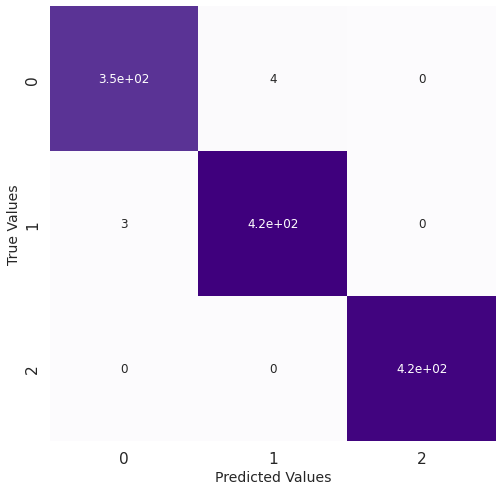

Classification Report
              precision    recall  f1-score   support

      Banana       0.99      0.99      0.99       357
Corn_(maize)       0.99      0.99      0.99       425
Pepper,_bell       1.00      1.00      1.00       416

    accuracy                           0.99      1198
   macro avg       0.99      0.99      0.99      1198
weighted avg       0.99      0.99      0.99      1198

----------------------------------------------------------------------------------------------------
Disease Confusion Matrix
[[ 72   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0]
 [  0   0 602   0   0   0   7]
 [  0   0   0  63   0  10   1]
 [  0   0   0   0  61   0   0]
 [  0   0   0   3   0  80   0]
 [  0   0   4   0   0   0 199]]


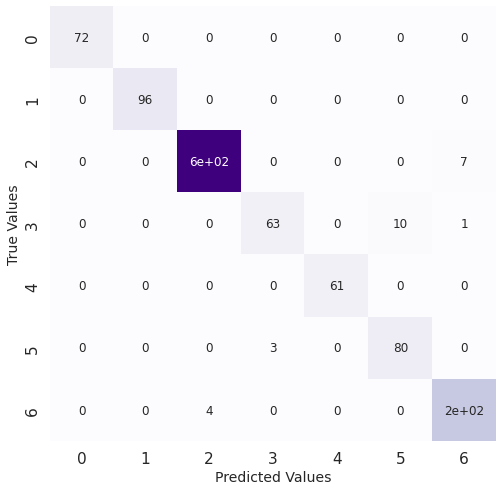

Classification Report
                                     precision    recall  f1-score   support

                             Panama       1.00      1.00      1.00        72
                           Sigatoka       1.00      1.00      1.00        96
                            healthy       0.99      0.99      0.99       609
Cercospora_leaf_spot Gray_leaf_spot       0.95      0.85      0.90        74
                       Common_rust_       1.00      1.00      1.00        61
               Northern_Leaf_Blight       0.89      0.96      0.92        83
                     Bacterial_spot       0.96      0.98      0.97       203

                           accuracy                           0.98      1198
                          macro avg       0.97      0.97      0.97      1198
                       weighted avg       0.98      0.98      0.98      1198



In [166]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
print('Species Confusion Matrix')
cm = confusion_matrix(labels_species, predicted_species_labels)
print(cm)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

print('Classification Report')
target_names = specie_list
print(classification_report(labels_species, predicted_species_labels, target_names=target_names))

print('----------------------------------------------------------------------------------------------------')


print('Disease Confusion Matrix')
cm = confusion_matrix(labels_diseases, predicted_diseases_labels)
print(cm)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

print('Classification Report')
target_names = disease_list
print(classification_report(labels_diseases, predicted_diseases_labels, target_names=target_names))

### Visualization with GradCam

In [ ]:
tf.keras.utils.plot_model(pretained_multi_model_short, show_shapes=True)

In [ ]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      # return predictions
      loss = predictions[0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)
    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img_rgb

In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed

def predict_and_interpret(img_path, model, model_name, layers):
  '''
  Used for quick prediction and gradcam interpretation of external images not included
  in the original validation dataset. Primary use is to find cases the model has trouble
  with.
  '''
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
  pred = decode_prediction(pred_raw)
  pred_label = class_info[pred]
  fused = fuse_layers(layers, model, img)

  return img, fused, pred_raw

def produce_course_semantic_segmentation(fused, img, thresh):
  '''
  Segments out red areas on a Grad-CAM heat-map based on a threshold.
  Then filters the original image based on the red area and returns the "masked"
  image.
  '''
  mask = np.where((fused[:, :, 0] == 255) & (fused[:, :, 1] < thresh) & (fused[:, :, 2] < thresh), 1.0, 0.0)
  mask = mask.astype(bool)
  masked_img = img.copy()
  masked_img[~mask] = 0
  return masked_img

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [ ]:
pretained_multi_model_short.layers

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
import cv2

layer_name = 'pool_1'
img = image_batch[8].numpy()
img = img.astype(np.uint8)
grad_cam=GradCam(pretained_multi_model_short,np.expand_dims(img, axis=0),layer_name)
# print(len(grad_cam[1][0]))
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last Conv Layer Grad-CAM heat-map')
plt.tight_layout()

### Visualization Single Task Model

In [ ]:
y = np.concatenate([y for x, y in validation_dataset], axis=0)

In [ ]:
x = np.concatenate([x for x, y in validation_dataset], axis=0)

In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [ ]:
 validation_dataset.take(tf.data.experimental.cardinality(validation_dataset))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      precision_m,
      recall_m,
      f1_m
]


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:

inputs = tf.keras.Input(shape=(224, 224, 3))

x = tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_shape=(224,224,3))

for layer in x.layers:
	layer.trainable = False
    
flat1 = global_average_layer(x.layers[-1].output)
flat2 = tf.keras.layers.Dropout(0.2)(flat1)
class1 = Dense(1024, activation='relu')(flat2)
output = Dense(38, activation='softmax')(class1)
model = tf.keras.Model(inputs=x.inputs, outputs=output)
model.summary()

In [ ]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)
    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img_rgb

In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed

def predict_and_interpret(img_path, model, model_name, layers):
  '''
  Used for quick prediction and gradcam interpretation of external images not included
  in the original validation dataset. Primary use is to find cases the model has trouble
  with.
  '''
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
  pred = decode_prediction(pred_raw)
  pred_label = class_info[pred]
  fused = fuse_layers(layers, model, img)

  return img, fused, pred_raw

def produce_course_semantic_segmentation(fused, img, thresh):
  '''
  Segments out red areas on a Grad-CAM heat-map based on a threshold.
  Then filters the original image based on the red area and returns the "masked"
  image.
  '''
  mask = np.where((fused[:, :, 0] == 255) & (fused[:, :, 1] < thresh) & (fused[:, :, 2] < thresh), 1.0, 0.0)
  mask = mask.astype(bool)
  masked_img = img.copy()
  masked_img[~mask] = 0
  return masked_img

In [ ]:
import cv2

layer_name = 'block5_pool'
img = image_batch[14].numpy()
img = img.astype(np.uint8)
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Last Conv Layer Grad-CAM heat-map')
plt.tight_layout()

In [ ]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if isinstance(layer, tf.keras.layers.Conv2D)]


In [ ]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(conv2D_layers[:35]):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

### Deconvolution

In [ ]:
%matplotlib inline
%load_ext tensorboard
import shutil
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import sklearn.metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from keras import backend as K

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from glob2 import glob

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

data_dir = "/content/plantvillage dataset/color"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

In [ ]:
from keras import backend as K
from keras import __version__
from keras.applications.vgg16 import VGG16
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.regularizers import l2,l1
import tensorflow as tf
from tensorflow.python.framework import ops

input_shape = (224,224,3)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
inputs = tf.keras.Input(shape=input_shape)
base_model1 = tf.keras.applications.VGG16(include_top=False, input_tensor=preprocess_input(inputs), weights='imagenet',input_shape = input_shape)
x1_0 = base_model1.output
x1_0 = Flatten(name='Flatten1')(x1_0)
x1_1 = Dense(256, name='fc1',activation='relu')(x1_0) 
x1_2 = Dense(38, name='out1', activation = 'softmax')(x1_1)

print('VGG output: ', x1_0.shape); 
print('Teacher Decision: ', x1_2);  

print('Decoder')

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      precision_m,
      recall_m,
      f1_m
]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path = '/output/Checkpoint/'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
initial_epochs = 5
model = Model(inputs = base_model1.inputs, outputs = x1_2)
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)
history = model.fit(train_dataset,
                    batch_size=32,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=keras_callbacks)

In [ ]:
#Decoder's graph.	
#Get Teacher's tensors for skip connection.
pool5 = base_model1.get_layer('block5_pool').output
print('pooling5: ', pool5.shape)
conv5 = base_model1.get_layer('block5_conv3').output
print('conv5: ', conv5.shape)
conv4 = base_model1.get_layer('block4_conv3').output
print('conv4: ', conv4.shape)
conv3 = base_model1.get_layer('block3_conv3').output
print('conv3: ', conv3.shape)
conv2 = base_model1.get_layer('block2_conv2').output
print('conv2: ', conv2.shape)
conv1 = base_model1.get_layer('block1_conv2').output
print('conv1: ', conv1.shape)

#Inverse fully connected Teacher's layers. 
inv_x1_1 = Dense(256, name='inv_x1_1',activation='relu')(x1_2)
merge_x1_1 = Add(name='merge_x1_1')([inv_x1_1,x1_1])
inv_x1_0 = Dense(7*7*512, name='x1_1',activation='relu')(merge_x1_1)
reshaped_inv_x1_0 = Reshape((7, 7,512), name='')(inv_x1_0)
inv_x1_0 = Add(name='merge_x1_0')([reshaped_inv_x1_0,pool5])

#DECONV Block1
up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(inv_x1_0))
print('up7: ', up7)

merge7 = concatenate([conv5,up7], axis = 3)
conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#DECONV Block2
up8 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv4,up8], axis = 3)
conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#DECONV Block13
up9 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv3,up9], axis = 3)
conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

#DECONV Block14
up10 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
merge10 = concatenate([conv2,up10], axis = 3)
conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)

#DECONVBlock15
up11 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
merge11 = concatenate([conv1,up11], axis = 3)
conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
#Reconstructed image refinement
conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
mask = conv11 = Conv2D(3, 1, activation = 'sigmoid',name='Mask')(conv11)

In [ ]:
mask_model = Model(inputs = base_model1.inputs, outputs = mask)
# mask_model.predict(img)

In [ ]:
model.save('./encoder.h5')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

layer_name = 'block5_pool'
img = image_batch[16].numpy()
img = img.astype(np.uint8)
mask = mask_model.predict(np.expand_dims(img, axis=0))

In [ ]:
im = Image.open(r"/content/temp.png")
im1 = Image.Image.split(im)
  
# showing each band
plt.imshow(im1[2])

In [ ]:
im1[1]

In [ ]:
im1[2]

In [ ]:
lower_leaf = (0, 0, 238)
upper_leaf = (22, 255, 255)

img = image_batch[14].numpy()
img = img.astype(np.uint8)# hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# leaf_mask = cv2.inRange(img, lower_leaf, upper_leaf)
leaf_result = cv2.bitwise_and(img, img, mask=np.array(im1[2]))
# leaf_result
# _, leaf_mask = cv2.threshold(leaf_mask, thresh=np.unique(leaf_result)[0], maxval=255, type=cv2.THRESH_BINARY)

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(leaf_result)

### Commands

In [ ]:
import shutil

shutil.rmtree('/content/Augmented Malaysaiplant Dataset')